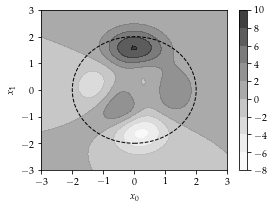

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from oodx import DataBlock, GPR, GPC, NN, MPBlock, AdaptiveSampler
from utils2 import (
    BlackBox, plot_underlying, plot_samples, plot_gpr, plot_gpc, plot_gp_opt, plot_gp_adaptive_opt, plot_nnr,
    plot_nnc, plot_nn_opt, plot_nn_adaptive_opt, plot_bayesian_opt, plot_direct_search
)

import numpy as np
import pandas as pd
import pyomo.environ as pyo
from sklearn.metrics import mean_absolute_error, precision_score, recall_score
import time
import copy
import matplotlib.pyplot as plt

plot_underlying()

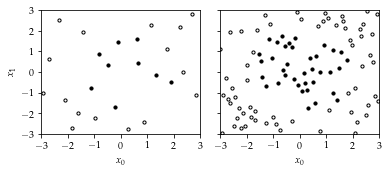

In [2]:
bb = BlackBox()
space = [[-3.0, 3.0], [-3.0, 3.0]]

db = DataBlock(inputs=['x0', 'x1'], outputs=['y'], targets=True)
db.static_sample(25, space)
db.data.y = bb.sample_y(db.data[['x0', 'x1']].values)
db.data.t = bb.sample_t(db.data[['x0', 'x1']].values)

db2 = DataBlock(inputs=['x0', 'x1'], outputs=['y'], targets=True)
db2.static_sample(100, space)
db2.data.y = bb.sample_y(db2.data[['x0', 'x1']].values)
db2.data.t = bb.sample_t(db2.data[['x0', 'x1']].values)

db3 = DataBlock(inputs=['x0', 'x1'], outputs=['y'], targets=True)
db3.static_sample(500, space)
db3.data.y = bb.sample_y(db3.data[['x0', 'x1']].values)
db3.data.t = bb.sample_t(db3.data[['x0', 'x1']].values)

plot_samples(db, db2)
plt.savefig('../figures/samples.png', dpi=500)

1.113650311874396
0.04498675888551416


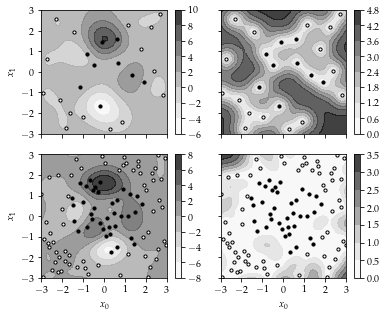

In [3]:
gpr = GPR()
gpr.fit(db.scaled_inputs.to_numpy(), db.scaled_outputs.to_numpy(), iprint=0)
pred = gpr.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db.inv_scale_outputs(pred)[db3.data.t==1]))

gpr2 = GPR()
gpr2.fit(db2.scaled_inputs.to_numpy(), db2.scaled_outputs.to_numpy(), iprint=0)
pred2 = gpr2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db2.inv_scale_outputs(pred2)[db3.data.t==1]))

plot_gpr(db, db2, gpr, gpr2)
plt.savefig('../figures/gpr.png', dpi=500)

0.9344262295081968 0.9344262295081968
0.9825581395348837 0.9234972677595629


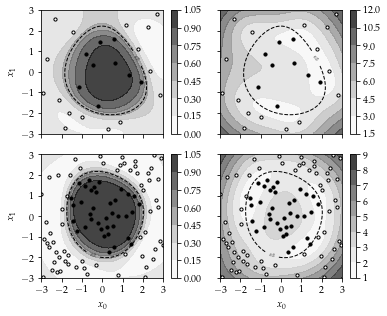

In [4]:
gpc = GPC()
gpc.fit(db.scaled_inputs.to_numpy(), db.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = gpc.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

gpc2 = GPC()
gpc2.fit(db2.scaled_inputs.to_numpy(), db2.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = gpc2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

plot_gpc(db, db2, gpc, gpc2)
plt.savefig('../figures/gpc.png', dpi=500)

In [5]:
def pyomo_problem(space, p):
    m = pyo.ConcreteModel()
    m.n_inputs = set(range(len(space)))
    m.inputs = pyo.Var(m.n_inputs, bounds=space)
    m.output = pyo.Var()
    m.prob = pyo.Var()
    m.feasibility_con = pyo.Constraint(expr= m.prob >= p)
    m.obj = pyo.Objective(expr=m.output, sense=pyo.maximize)
    return m

def gp_algorithm_results(m, d, gp, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['prob'] = m.prob.value
    results['err'] = mean_absolute_error(testing.data.y[testing.data.t==1], d.inv_scale_outputs(gp.predict(d.scale_inputs(testing.data[['x0', 'x1']]).to_numpy()))[testing.data.t==1])
    results['unc'] = 1.96 * d.std_outputs.to_numpy().ravel()[0] * gp.predict(x, return_std=1)[1].ravel()[0]
    results['tsol'] = t[2] - t[1]
    results['ttot'] = t[2] - t[0]
    return results

def gp_global_dfo(db, gpr, gpc, solver, testing):
    times = [time.time()]
    omo = pyomo_problem(db.scaled_space, 0.5)

    gpr_block = MPBlock(gpr)
    gpc_block = MPBlock(gpc)
    omo.gpr = gpr_block.get_formulation()
    omo.gpc = gpc_block.get_formulation()

    omo.connectors = pyo.ConstraintList()
    omo.connectors.add(omo.output == omo.gpr.outputs[0])
    omo.connectors.add(omo.prob == omo.gpc.outputs[0])
    for i in omo.n_inputs:
        omo.connectors.add(omo.inputs[i] == omo.gpr.inputs[i])
        omo.connectors.add(omo.inputs[i] == omo.gpc.inputs[i])

    times.append(time.time())
    solver.solve(omo, tee=True)
    times.append(time.time())

    results = gp_algorithm_results(omo, db, gpr, testing, times)
    
    return results

In [ ]:
solver = pyo.SolverFactory('baron')
# solver.options['MaxTime'] = 120
results1 = gp_global_dfo(db, gpr, gpc, solver, db3)
results2 = gp_global_dfo(db2, gpr2, gpc2, solver, db3)

plot_gp_opt(db, db2, gpr, gpr2, gpc, gpc2, results1[['x0*', 'x1*']], results2[['x0*', 'x1*']])
plt.savefig('../figures/gpopt.png', dpi=500)

print(results1)
print(results2)

 BARON version 22.9.30. Built: OSX-64 Fri Sep 30 09:08:44 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value 0.492902
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value 1.77573
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
          1             1            2

In [ ]:
def dim_convergence_check(bounds, tol):
    if bounds[1] - bounds[0] <= tol:
        print('dimension converged')
        return 1
    else:
        return 0
    
def convergence_check(space, tol):
    checks = []
    for dim, bounds in enumerate(space):
        if dim_convergence_check(bounds, tol):
            checks.append(1)
    if len(checks) == len(space):
        print('converged')
        return 1
    else:
        return 0

def bt(space0, space, shrink, sol, tol, prox=0.001):
    for dim, (lb, ub) in enumerate(space):
        if dim_convergence_check(space[dim], tol) == 1:
            space[dim] = [sol[dim] - tol / 2, sol[dim] + tol / 2]
        elif sol[dim] <= lb + prox:
            print('lower bound active')
            space[dim] = [sol[dim] - (ub - lb) / 2, sol[dim] + (ub - lb) / 2]
        elif sol[dim] >= ub - prox:
            print('upper bound active')
            space[dim] = [sol[dim] - (ub - lb) / 2, sol[dim] + (ub - lb) / 2]
        else:
            print('shrinking dimension...')
            new_size = (ub - lb) * shrink
            space[dim] = [sol[dim] - new_size / 2, sol[dim] + new_size / 2]
    return space

def gp_adaptive_results(m, d, gp, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['prob'] = m.prob.value
    results['err'] = mean_absolute_error(testing.y[testing.t==1], d.inv_scale_outputs(gp.predict(d.scale_inputs(testing[['x0', 'x1']]).to_numpy()))[testing.t==1])
    results['unc'] = 1.96 * d.std_outputs.to_numpy().ravel()[0] * gp.predict(x, return_std=1)[1].ravel()[0]
    results['tads'] = t[2] - t[1]
    results['tomo'] = t[4] - t[3]
    results['ttot'] = t[5] - t[0]
    return results

def gp_adaptive_dfo(space, d, gpr, gpc, max_iter, solver, testing):
    for iteration in range(max_iter):
        times = [time.time()]
        
        gpr_block = MPBlock(gpr)
        gpc_block = MPBlock(gpc)
        
        omo = pyomo_problem(d.scale_space(space), 0.5)
        omo.gpr = gpr_block.get_formulation()
        omo.gpc = gpc_block.get_formulation()
        omo.connectors = pyo.ConstraintList()
        omo.connectors.add(omo.output == omo.gpr.outputs[0])
        omo.connectors.add(omo.prob == omo.gpc.outputs[0])
        for i in omo.n_inputs:
            omo.connectors.add(omo.inputs[i] == omo.gpr.inputs[i])
            omo.connectors.add(omo.inputs[i] == omo.gpc.inputs[i])
            
        ads = AdaptiveSampler(d.scale_space(space))
        mod = ads.max_gp_std(gpr)
        mod.gpc = gpc_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.gpc.outputs[0] >= 0.5)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.gpc.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        obj = d.inv_scale_outputs(np.array(omo.output.value).reshape(1, -1)).ravel()
        print(obj)
        plot_gp_adaptive_opt(d, gpr, gpc, x.ravel(), ads_x.ravel(), space)
        plt.savefig('../figures/gp_adaptive{}.png'.format(iteration), dpi=500)

        space = bt(d.space, space, 0.9, x.ravel(), 0.5)
        
        times.append(time.time())
        
        if iteration == 0:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = gp_adaptive_results(omo, d, gpr, test_data, times)
        else:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = pd.concat([results, gp_adaptive_results(omo, d, gpr, test_data, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        gpr = GPR()
        gpr.fit(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), iprint=0)
        gpc = GPC()
        gpc.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)
        
        if convergence_check(space, 0.5) == 1:
            break
            
    return results.T

In [ ]:
baron = pyo.SolverFactory('baron')
baron.options['NumLoc'] = 50
baron.options['MaxIter'] = 0

adb = copy.deepcopy(db)
agpr = copy.deepcopy(gpr)
agpc = copy.deepcopy(gpc)
aspace = copy.deepcopy(space)

results3 = gp_adaptive_dfo(aspace, adb, agpr, agpc, 50, baron, db3)
print(results3)

In [ ]:
nnr = NN([2, 10, 10, 1], 'relu')
nnr.fit(db.scaled_inputs.to_numpy(), db.scaled_outputs.to_numpy(), iprint=0)
pred = nnr.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db.inv_scale_outputs(pred)[db3.data.t==1]))

nnr2 = NN([2, 10, 10, 1], 'relu')
nnr2.fit(db2.scaled_inputs.to_numpy(), db2.scaled_outputs.to_numpy(), iprint=0)
pred = nnr2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db2.inv_scale_outputs(pred)[db3.data.t==1]))

plot_nnr(db, db2, nnr, nnr2)
plt.savefig('../figures/nnr.png', dpi=500)

In [ ]:
nnc = NN([2, 20, 1], 'relu', is_classifier=True)
nnc.fit(db.scaled_inputs.to_numpy(), db.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = nnc.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

nnc2 = NN([2, 20, 1], 'relu', is_classifier=True)
nnc2.fit(db2.scaled_inputs.to_numpy(), db2.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = nnc2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

plot_nnc(db, db2, nnc, nnc2)
plt.savefig('../figures/nnc.png', dpi=500)

In [ ]:
def nn_algorithm_results(m, d, nn, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['lgt'] = m.prob.value
    results['err'] = mean_absolute_error(testing.data.y[testing.data.t==1], d.inv_scale_outputs(nn.predict(d.scale_inputs(testing.data[['x0', 'x1']]).to_numpy()))[testing.data.t==1])
    results['tsol'] = t[2] - t[1]
    results['ttot'] = t[2] - t[0]
    return results

def nn_global_dfo(db, nnr, nnc, solver, testing):
    times = [time.time()]
    omo = pyomo_problem(db.scaled_space, 0.0)

    nnr_block = MPBlock(nnr)
    nnc_block = MPBlock(nnc)
    omo.nnr = nnr_block.get_formulation()
    omo.nnc = nnc_block.get_formulation()

    omo.connectors = pyo.ConstraintList()
    omo.connectors.add(omo.output == omo.nnr.outputs[0])
    omo.connectors.add(omo.prob == omo.nnc.outputs[0])
    for i in omo.n_inputs:
        omo.connectors.add(omo.inputs[i] == omo.nnr.inputs[i])
        omo.connectors.add(omo.inputs[i] == omo.nnc.inputs[i])

    times.append(time.time())
    solver.solve(omo, tee=True)
    times.append(time.time())

    results = nn_algorithm_results(omo, db, nnr, testing, times)
    
    return results

In [ ]:
solver = pyo.SolverFactory('baron')
solver.options['MaxTime'] = 30
results4 = nn_global_dfo(db, nnr, nnc, solver, db3)
results5 = nn_global_dfo(db2, nnr2, nnc2, solver, db3)

plot_nn_opt(db, db2, nnr, nnr2, nnc, nnc2, results4[['x0*', 'x1*']], results5[['x0*', 'x1*']])
plt.savefig('../figures/nnopt.png', dpi=500)
print(results4)
print(results5)

In [ ]:
def nn_adaptive_results(m, d, nn, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['lgt'] = m.prob.value    
    results['err'] = mean_absolute_error(testing.y[testing.t==1], d.inv_scale_outputs(nn.predict(d.scale_inputs(testing[['x0', 'x1']]).to_numpy()))[testing.t==1])
    results['tads'] = t[2] - t[1]
    results['tomo'] = t[4] - t[3]
    results['ttot'] = t[5] - t[0]
    return results


def nn_adaptive_dfo(space, d, nnr, nnc, max_iter, solver, testing):
    for iteration in range(max_iter):
        times = [time.time()]
        
        nnr_block = MPBlock(nnr)
        nnc_block = MPBlock(nnc)
        
        omo = pyomo_problem(d.scale_space(space), 0.0)
        omo.nnr = nnr_block.get_formulation()
        omo.nnc = nnc_block.get_formulation()
        omo.connectors = pyo.ConstraintList()
        omo.connectors.add(omo.output == omo.nnr.outputs[0])
        omo.connectors.add(omo.prob == omo.nnc.outputs[0])
        for i in omo.n_inputs:
            omo.connectors.add(omo.inputs[i] == omo.nnr.inputs[i])
            omo.connectors.add(omo.inputs[i] == omo.nnc.inputs[i])
            
        ads = AdaptiveSampler(d.scale_space(space))
        mod = ads.max_triangle(d.scaled_inputs.to_numpy(), include_vertices=1)
        mod.nnc = nnc_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.nnc.outputs[0] >= 0.0)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.nnc.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        obj = d.inv_scale_outputs(np.array(omo.output.value).reshape(1, -1)).ravel()
        plot_nn_adaptive_opt(d, nnr, nnc, x.ravel(), ads_x.ravel(), space, ads)
        plt.savefig('../figures/nn_adaptive{}.png'.format(iteration), dpi=500)
        
        nnr = NN([2, 10, 10, 1], 'relu')
        nnr.fit(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), iprint=0)
        nnc = NN([2, 20, 1], 'relu', is_classifier=True)
        nnc.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)

        space = bt(d.space, space, 0.9, x.ravel(), 0.5)
        
        times.append(time.time())
        if iteration == 0:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = nn_adaptive_results(omo, d, nnr, test_data, times)
        else:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = pd.concat([results, nn_adaptive_results(omo, d, nnr, test_data, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        
        if convergence_check(space, 0.5) == 1:
            break
            
    return results.T

In [ ]:
baron = pyo.SolverFactory('baron')

adb = copy.deepcopy(db)
annr = copy.deepcopy(nnr)
annc = copy.deepcopy(nnc)
aspace = copy.deepcopy(space)

results6 = nn_adaptive_dfo(aspace, adb, annr, annc, 50, baron, db3)
print(results6)

In [ ]:
def gp_bayesian_dfo(space, d, gpr, gpc, max_iter, solver, testing):
    for iteration in range(max_iter):
        times = [time.time()]
        
        gpr_block = MPBlock(gpr)
        gpc_block = MPBlock(gpc)
        
        omo = pyomo_problem(d.scale_space(space), 0.5)
        omo.gpr = gpr_block.get_formulation()
        omo.gpc = gpc_block.get_formulation()
        omo.connectors = pyo.ConstraintList()
        omo.connectors.add(omo.output == omo.gpr.outputs[0])
        omo.connectors.add(omo.prob == omo.gpc.outputs[0])
        for i in omo.n_inputs:
            omo.connectors.add(omo.inputs[i] == omo.gpr.inputs[i])
            omo.connectors.add(omo.inputs[i] == omo.gpc.inputs[i])
            
        ads = AdaptiveSampler(d.scale_space(space))
        mod = ads.modified_expected_improvement(gpr, d.scaled_outputs.to_numpy(), 'max')
        mod.gpc = gpc_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.gpc.outputs[0] >= 0.5)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.gpc.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        obj = d.inv_scale_outputs(np.array(omo.output.value).reshape(1, -1)).ravel()
        ystar = np.max(d.scaled_outputs.to_numpy())
        plot_bayesian_opt(d, gpr, gpc, x.ravel(), ads_x.ravel(), ystar)
        plt.savefig('../figures/gp_bayesian{}.png'.format(iteration), dpi=500)

        gpr = GPR()
        gpr.fit(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), iprint=0)
        gpc = GPC()
        gpc.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)
    
        times.append(time.time())
        
        if iteration == 0:
            results = gp_adaptive_results(omo, d, gpr, testing.data, times)
        else:
            results = pd.concat([results, gp_adaptive_results(omo, d, gpr, testing.data, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        
        if mod.mod_ei.value < 0.01:
            print('modified expected improvement converged')
            break
        
    return results.T

In [ ]:
baron = pyo.SolverFactory('baron')
baron.options['NumLoc'] = 50
baron.options['MaxIter'] = 0

adb = copy.deepcopy(db)
agpr = copy.deepcopy(gpr)
agpc = copy.deepcopy(gpc)
aspace = copy.deepcopy(space)

results7 = gp_bayesian_dfo(aspace, adb, agpr, agpc, 50, baron, db3)
print(results7)

In [ ]:
def direct_search_results(m, d, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = np.max(d.data.y.to_numpy())
    results['lgt'] = m.clf.outputs[0].value
    results['tads'] = t[2] - t[1]
    results['tomo'] = t[4] - t[3]
    results['ttot'] = t[5] - t[0]
    return results

def direct_search_dfo(space, d, clf, max_iter, solver, testing):
    results = {}
    for iteration in range(max_iter):
        times = [time.time()]
        
        ads = AdaptiveSampler(d.scale_space(space))
        clf_block = MPBlock(clf)

        omo = ads.exploit_triangle(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), 'max', include_vertices=0)
        omo.clf = clf_block.get_formulation()
        omo.feas = pyo.Constraint(expr=omo.clf.outputs[0] >= 0.0)
        omo.connectors = pyo.ConstraintList()
        for i in omo.n_inputs:
            omo.connectors.add( omo.inputs[i] == omo.clf.inputs[i] )
            
        mod = ads.max_triangle(d.scaled_inputs.to_numpy(), include_vertices=0)
        mod.clf = clf_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.clf.outputs[0] >= 0.0)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.clf.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        plot_direct_search(d, clf, x.ravel(), ads_x.ravel(), ads)
        plt.savefig('../figures/direct_search{}.png'.format(iteration), dpi=500)
        
        times.append(time.time())
        
        if iteration == 0:
            results = direct_search_results(omo, d, times)
        else:
            results = pd.concat([results, direct_search_results(omo, d, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        d.data.loc[len(d.data), :] = [*x[0], *bb.sample_y(x)[0], *bb.sample_t(x)[0]]
        clf = NN([2, 20, 1], 'relu', is_classifier=True)
        clf.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)
        
        if iteration > 0:
            x_dist = np.sqrt(sum((results[iteration][i] - results[iteration - 1][i]) ** 2 for i in ['x0*', 'x1*']))
            if x_dist < 0.01:
                print('direct search converged')
                break
        
    return results.T

In [ ]:
baron = pyo.SolverFactory('baron')

adb = copy.deepcopy(db)
annc = copy.deepcopy(nnc)
aspace = copy.deepcopy(space)

results8 = direct_search_dfo(aspace, adb, annc, 50, baron, db3)
print(results8)

In [ ]:
print(results1)
print(results2)
print(results3)
print(results4)
print(results5)
print(results6)
print(results7)
print(results8)

In [ ]:
plt.plot(np.cumsum(results3.ttot), results3.err)
plt.plot(np.cumsum(results6.ttot), results6.err)
plt.plot(np.cumsum(results7.ttot), results7.err)

print(results1.err, results1.ttot)
print(results2.err, results2.ttot)

print(results4.err, results4.ttot)
print(results5.err, results5.ttot)

print(sum(results8.ttot))

In [ ]:
plt.plot(np.cumsum(results3.ttot), results3.obj)
plt.plot(np.cumsum(results6.ttot), results6.obj)
plt.plot(np.cumsum(results7.ttot), results7.obj)
plt.plot(np.cumsum(results8.ttot), results8.obj)
plt.scatter(results1.ttot, results1.obj)

print(results1.obj, results1.ttot)
print(results2.obj, results2.ttot)

print(results4.obj, results4.ttot)
print(results5.obj, results5.ttot)